In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subprocess
import os
from os import path

In [37]:
# Prompt user for manual or automated argument
while (True):
    dataset_type = str(input("Please enter 'manual', 'automated', or 'both' for the type of data set you are processing: "))
    # make case insenstive
    dataset_type = dataset_type.lower()
    if (dataset_type == "manual" or dataset_type == "automated" or dataset_type == 'both'):
        break
    print("Invalid argument")

Please enter 'manual', 'automated', or 'both' for the type of data set you are processing: both


In [38]:
# Ask user if running analysis on a new cruise
while (True):
    reply = str(input('Are you running the analysis on a new cruise? (y/n): ')).lower().strip()
    if reply[0] == 'y':
        break
    if reply[0] == 'n':
        break
    else:
        print("Please enter y/n")

Are you running the analysis on a new cruise? (y/n): n


In [39]:
# first call bash script to get necessary file inputs
# choose man_query_data.csv as input file during file 1b construction, then names_ids.csv for R prompts
# only call if files don't exist or calling on new cruise data so program doesn't need to take full time to run
if ( not reply[0] != 'y' or not (path.exists('resolved_auto.csv') 
        and path.exists('resolved_manual.csv') and path.exists('comparison.csv'))):
    print("hi")
    # subprocess.call(['./exec.sh', reply[0]])

In [40]:
# read different columns based on dataset type
if (dataset_type == 'manual'):
    columns = ['permalink', 'namespace_manual', 'worms_higher_order_manual']
elif (dataset_type == 'automated'):
    columns = ['permalink', 'namespace_automated']
else:
    columns = ['permalink', 'namespace_manual', 'namespace_automated', 'worms_higher_order_manual']

In [41]:
# initialize data frame from input
samples = pd.read_csv("level_1b.csv", usecols=columns)

In [42]:
# get higher order data based on dataset
if (dataset_type == 'automated'):
    auto_taxon_info = pd.read_csv('resolved_auto.csv', 
                                  usecols=['name', 'resolved_names', 'resolved_higher_order_fromgnr', 'alt_datasource'])
    # merge to get taxa data
    samples = pd.merge(samples, auto_taxon_info, how='left', left_on='namespace_automated', right_on='name')
    # rename resolved_higher_order column to match
    samples.rename(columns={'resolved_higher_order_fromgnr':'worms_higher_order_automated'}, inplace=True)
elif (dataset_type == 'manual'):
    man_taxon_info = pd.read_csv('resolved_manual.csv', 
                                  usecols=['name', 'resolved_names', 'alt_datasource'])
    # merge to get taxa data
    samples = pd.merge(samples, man_taxon_info, how='left', left_on='namespace_manual', right_on='name')
else:
    auto_taxon_info = pd.read_csv('resolved_auto.csv', 
                                  usecols=['name', 'resolved_names', 'resolved_higher_order_fromgnr', 'alt_datasource'])
    # merge to get taxa data
    samples = pd.merge(samples, auto_taxon_info, how='left', left_on='namespace_automated', right_on='name')
    # rename resolved_higher_order column to match
    samples.rename(columns={'resolved_higher_order_fromgnr':'worms_higher_order_automated'}, inplace=True)
    man_taxon_info = pd.read_csv('resolved_manual.csv', 
                                  usecols=['name', 'resolved_names'])
    # merge to get taxa data
    samples = pd.merge(samples, man_taxon_info, how='left', left_on='namespace_manual', right_on='name')

In [43]:
# separate out roi id from permalink
samples['roi'] = samples['permalink']
samples.roi = samples.roi.str.slice(68, 74)
# gets rid of leading zeros
samples.roi = samples.roi.str.lstrip("0")
# cut permalink to just be permalink of sample
samples.permalink = samples.permalink.str.slice(0, 67)

In [44]:
# read in geolocation data
geo_data = pd.read_csv("comparison.csv", usecols=['gps_furuno_latitude', 'pid'])
samples = pd.merge(samples, geo_data, how='left', left_on='permalink', right_on='pid')

In [45]:
# exclude abiotic particles from other
samples = samples[samples['alt_datasource'] != 'OCB']

In [46]:
# for now just use volume from original file- temporary fix
volume_data = pd.read_csv('IFCB_count_manual_transect_winter_2018_20190530.csv', 
                          usecols=['sample_identifier', 'volume_imaged'])
volume_data['sample_identifier'] = 'http://ifcb-data.whoi.edu/NESLTER_transect/'+volume_data['sample_identifier'].astype(str)
samples = pd.merge(samples, volume_data, how='inner', left_on='permalink', right_on='sample_identifier')

In [47]:
# calculate abundance based on higher order and latitude
if (dataset_type == 'both'):
    # need 2 data frames for both
    auto_samples = samples.groupby(['gps_furuno_latitude', 'worms_higher_order_automated']).agg(
    {
        'roi': 'count',
        'volume_imaged': 'first'
    }
).reset_index()
    # manual data frame
    manual_samples = samples.groupby(['gps_furuno_latitude', 'worms_higher_order_manual']).agg(
    {
        'roi': 'count',
        'volume_imaged': 'first'
    }
).reset_index()
else:
    samples = samples.groupby(['gps_furuno_latitude', 'worms_higher_order_{}'.format(dataset_type)]).agg(
        {
            'roi': 'count',
            'volume_imaged': 'first'
        }
    ).reset_index()

In [48]:
# calculate concentration from abundance and volume
if (dataset_type == 'both'):
    # calculate concentration for automated classifications
    auto_samples['concentration'] = auto_samples.roi/auto_samples.volume_imaged
    # convert to float
    auto_samples.concentration = auto_samples.concentration.astype(float)
    # calculate concentrations for manual classifications
    manual_samples['concentration'] = manual_samples.roi/manual_samples.volume_imaged
    # convert to float
    manual_samples.concentration = manual_samples.concentration.astype(float)
else:
    samples['concentration'] = samples.roi/samples.volume_imaged
    # convert to float
    samples.concentration = samples.concentration.astype(float)

In [49]:
# filter out to only read Diatoms
if (dataset_type == 'both'):
    auto_samples = auto_samples[auto_samples['worms_higher_order_automated'] == 'Bacillariophyceae'].reset_index()
    manual_samples = manual_samples[manual_samples['worms_higher_order_manual'] == 'Bacillariophyceae'].reset_index()
# else:
    # samples = samples[samples['worms_higher_order_{}'.format(dataset_type)] == 'Bacillariophyceae'].reset_index()

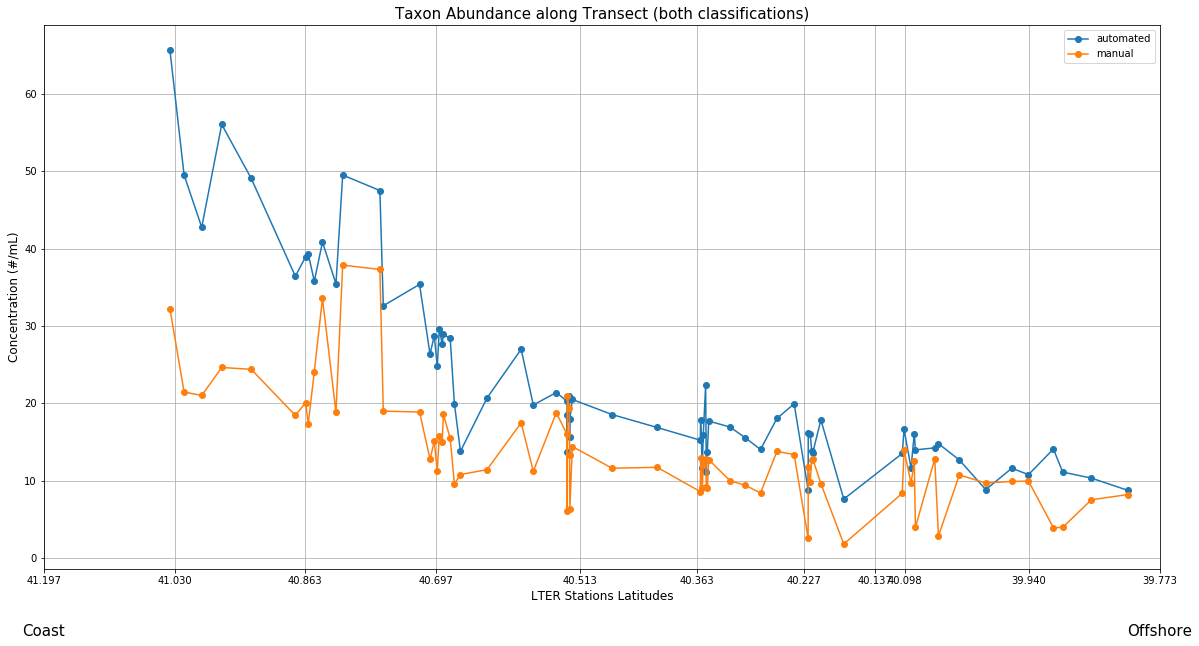

In [64]:
# take duplicate latitudes and add their concentrations together
fig, ax = plt.subplots(figsize=(20,10))
# use unstack()
if (dataset_type == 'both'):
    grouped = auto_samples.groupby(['gps_furuno_latitude', 'worms_higher_order_automated']).sum()['concentration']
    grouped.unstack().plot(ax=ax, marker='o')
    grouped = manual_samples.groupby(['gps_furuno_latitude', 'worms_higher_order_manual'.format(dataset_type)]).sum()['concentration']
    grouped.unstack().plot(ax=ax, marker='o')
    L=plt.legend()
    L.get_texts()[0].set_text('automated')
    L.get_texts()[1].set_text('manual')
else:
    grouped = samples.groupby(['gps_furuno_latitude', 'worms_higher_order_{}'.format(dataset_type)]).sum()['concentration']
    grouped.unstack().plot(ax=ax, marker='o')
# add titles and axes labels
plt.xlabel('LTER Stations Latitudes', size = 12)
plt.ylabel('Concentration (#/mL)', size = 12)
plt.title('Taxon Abundance along Transect ({} classifications)'.format(dataset_type), size = 15)
plt.grid(True)
# set stations as tick marks
ax.set_xticks([41.1967, 41.03, 40.8633, 40.6967, 40.5133, 40.3633, 40.2267, 40.1367, 40.0983, 39.94, 39.7733])
# ax.set_xticklabels(np.arange(1,12))
# set comments
ax.text(41.1967, -10, "Coast", size = 15, ha = 'center')
ax.text(39.7733, -10, "Offshore", size = 15, ha = 'center')
# invert x axis
ax.invert_xaxis()
plt.show()